

$$\zeta(r,z,t) = a_o e^{i \omega_o t} B_0( x, z) +  a_1 e^{i \omega_1 t} B_1(x,z) ...$$

$$
\begin{bmatrix}
d(x_o,z_o,t_o) \\
d(x_o,z_1,t_o) \\
d(x_o,z_2,t_o) \\
\vdots  \\
d(x_n,z_m,t_l) \\
\end{bmatrix}
=
\begin{bmatrix}
\phi_o(z_o) e^{i (k_{o} x_o - \omega_o t_o)  } & 
 \dots & 
 \phi_N(z_o) e^{i (k_{N} x_o - \omega_N t_o)  }\\ 
 \vdots & \ddots & \\
\phi_o(z_M) e^{i (k_{o} x_M - \omega_o t_M)  } & \dots & 
\phi_N(z_M) e^{i (k_{N} x_M - \omega_o t_M)  } \\
\end{bmatrix}
\cdot
\begin{bmatrix}
a_{000} \\
a_{100} \\
a_{110} \\
\vdots  \\
a_{n,m,l} \\
\end{bmatrix}
$$
Where N is the number of parameters and M is the number of data. In general the data and parameters are in multiple dimensions. Multi-dimensional data is flattened into a single vector. 

In [621]:
# Source Libraries
source('src/timeseries_analysis.r')

read_data_dir <- function(path,timesamples,epsi){
    #Setup datapath and read metafile
    meta    <- read_meta(path)
    
    #Read in the data
    ds <- merge_time_frames(path,timesamples)
    
    #Add some noise
    noise <- epsi*rnorm(length(ds$disp)) 
    ds$disp <- ds$disp + noise
    return (ds)
}


#Ocean profile
stratdf <- read_feather('config/strat.fthr')
strat   <- stratdf$strat
depth   <- seq(0,meta$depth_max,length.out=meta$depth_len)
range   <- seq(0,meta$range_max,length.out=meta$range_len)
    

#Sampling and Noise Params
recordstop <- 578-3*96
timesamples <- seq(1,recordstop,4)
epsi        <- 1e-3

paths <- list('../data/3d_250km','../data/3d_100km','../data/3d_50km','../data/3d_10km')
#paths <- list('../data/3d_250km')
dsl <- list()
i <- 1
for (p in paths){
    dsl[[i]] <- read_data_dir(p,timesamples,epsi)
    i<-i+1
}

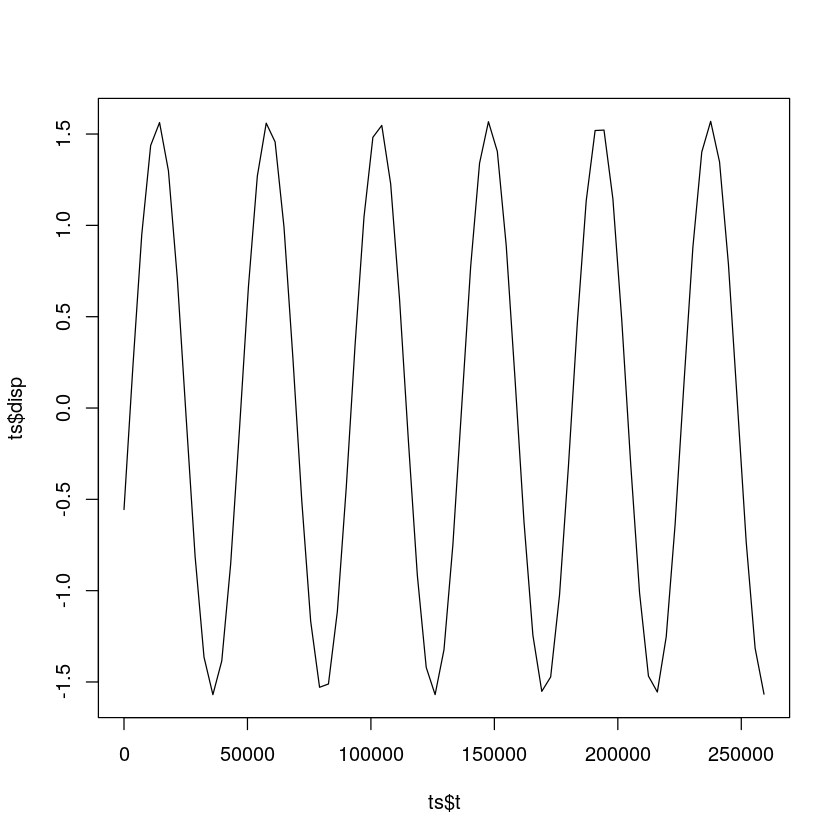

In [622]:
#Plot a time series at a specific spacial points
plot_ts <- function(ds,xi,yi,zi){
    xs <- unique(ds$x)[xi]
    ys <- unique(ds$y)[yi]
    zs <- unique(ds$z)[zi]
    ts <- ds[ ds$x==xs & ds$y == ys & ds$z == zs ,]
    plot(ts$t,ts$disp,type='l')
}
plot_ts(dsl[[1]],1,1,1)

In [623]:
#Remove last x position
#xs <- unique(ds$x)[4]
#print(xs)
#ds <- ds[!ds$x == xs,] 

In [624]:
#Make a initial parameter space
source('../src/inversion.r')

#Three parameters
modes <- seq(1,3,1)
omega <- seq(0.0805,0.1005,0.01)/3600
k <- generate_wavenumbers(depth,strat,omega,modes)

#Make a set of kx , ky
headings  <- seq(0,90,1)
kx <- ky <- c()
i <- 1
for (ks in k) {
    kx <- c(kx,ks*cos( pi * headings/180))
    ky <- c(ky,ks*sin( pi * headings/180))
    i <- i + 1
}

ps <- data.frame(k=rep(k,each=length(headings)),heading=headings, kx=kx,ky=ky,
                 omega=rep(omega,each=length(modes)*length(headings)),
                 modes=rep(modes,each=length(headings)) ) 

ps <- ps[order(ps$omega,ps$modes),]
nrow(ps)
omega

[1] 819

[1] 2.236111e-05 2.513889e-05 2.791667e-05

In [625]:
psl <- list()
i  <- 1

system.time(for (d in dsl){
    H <- make_inv_matrix(d,ps)
    approx <- tappered_least_square(H,d$disp)
    xl <- length(approx$x_hat)
    ps$a  <- approx$x_hat[1:(xl/2),]
    ps$b  <- approx$x_hat[(xl/2 + 1) :xl,]
    
    psl[[i]] <- ps
    i <- i + 1
} )



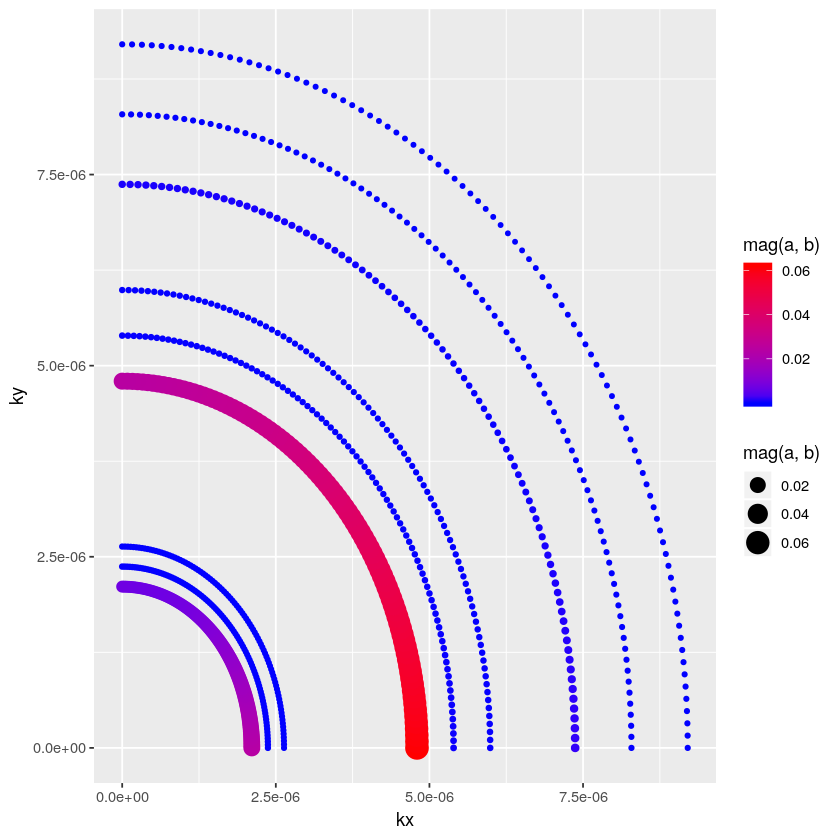

In [626]:
#Plot Square Amplitudes
library(gridExtra)
mag <- function(a,b){
    return ((a**2 + b**2))
}


plots <- list()
i <- 1
for (psi in psl){
    plots[[i]] <- ggplot(psi,aes(x=kx,y=ky,size=mag(a,b),color=mag(a,b))) + 
      geom_point() + 
      scale_color_gradient(low = "blue", high = "red")
    i <- i +1
}

plots[[4]]

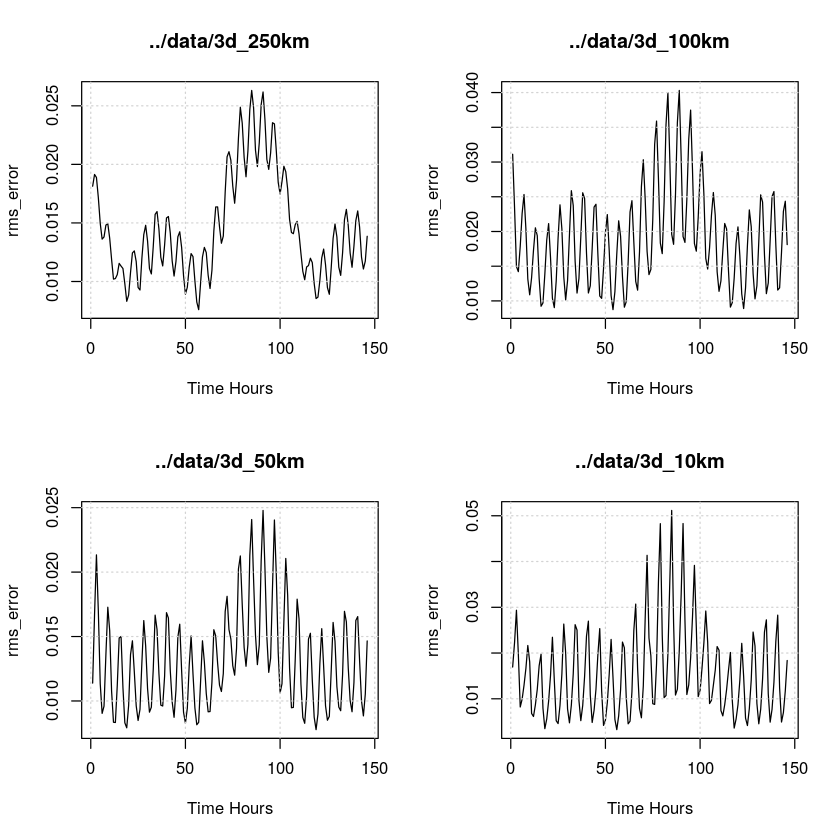

In [627]:
#Foward problem
make_forecast <- function(ds_fut,ps){
    a<-c(ps$a,ps$b)
    H2 <- make_inv_matrix(ds_fut,ps)
    ds_fut['disp_est'] <- H2%*%a
    return (ds_fut)
}

forecast_error <- function(ds_fut){
    rms_error <- c()
    time <- unique(ds_fut$t)
    for (tt in time ) {
        dt  <- ds_fut$disp[ds_fut$t == tt]
        de  <- ds_fut$disp_est[ds_fut$t == tt]
        rms_diff <- sqrt(mean( (dt - de)**2  ))
        rms_de   <- sqrt(mean( de**2 ) )
        rms_error <- c(rms_error,rms_diff/rms_de)
    }
    return(rms_error)
}


#Read in the next day
timesamples <- seq(recordstop,578,4)

rms_errors <- list()
i <- 1
for (p in paths){
    ds_fut <- read_data_dir(p,timesamples,epsi)
    ds_fut <- rbind(dsl[[i]],ds_fut)
    ds_fut <- make_forecast(ds_fut,psl[[i]]) 
    rms_errors[[i]] <- forecast_error(ds_fut)
    i<-i+1
}

par(mfrow=c(2,2))
i <- 1
for (rms_error in rms_errors){
    plot(rms_error,type='l',xlab="Time Hours")
    title(paths[[i]])
    grid()    
    i <- i + 1
}



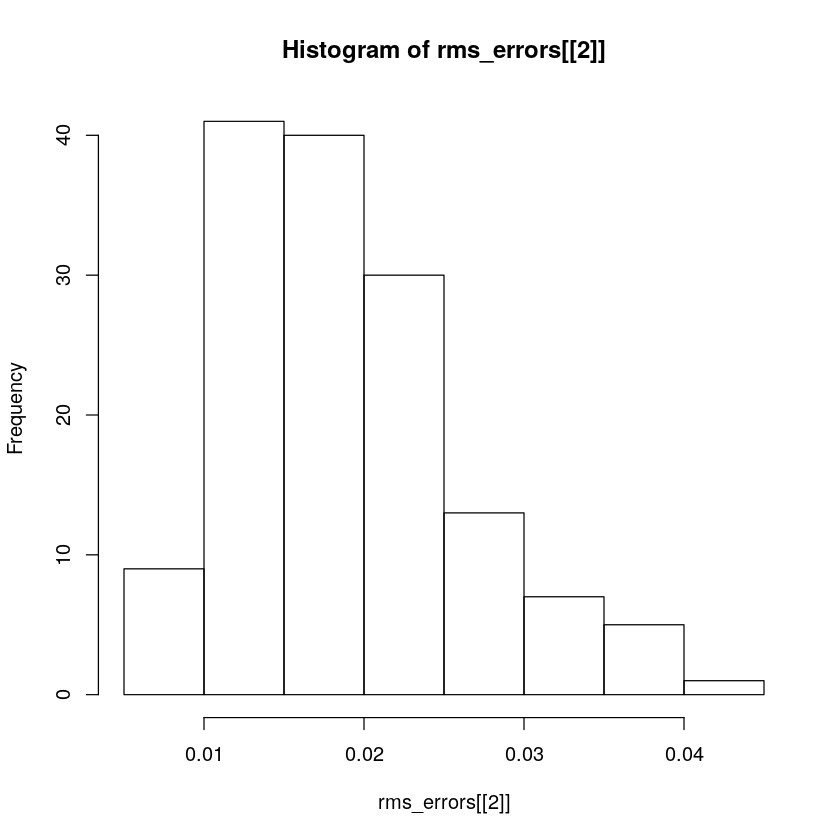

In [632]:
hist(rms_errors[[2]])

In [628]:
M <- t(H)%*%H


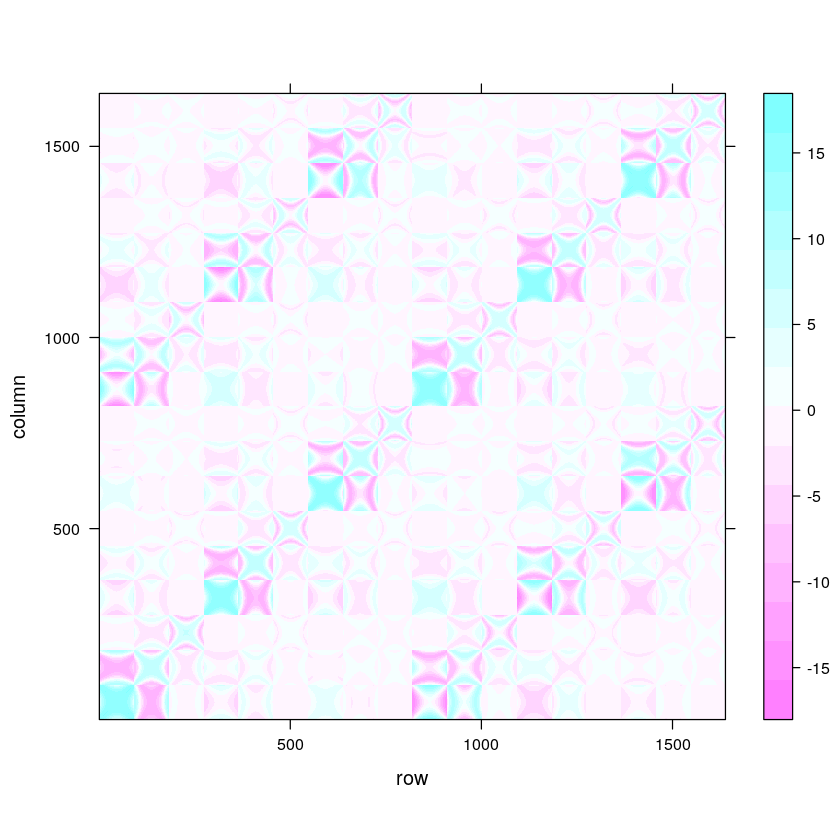

In [629]:
library(lattice)
levelplot(M)